In [72]:
import pandas as pd
import networkx as nx
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import TransformerConv
from torch_geometric.nn import GATConv

from torch_geometric.nn import GCNConv
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.utils import from_networkx
from sklearn.metrics import confusion_matrix, classification_report
import os
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt
import glob
import time

from torch.nn import LSTM


import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [73]:
from sklearn import metrics

class Classification_performance_metrics_modified:
    def __init__(self,o_labels,p_labels,file_name):
        self.original = o_labels
        self.predicted = p_labels
        self.filename=file_name
        
        with open(f"{file_name}.txt","w") as file:
            file.write(f"Accuracy: {self.get_accuracy_score()}\n")
            file.write(f"metric.balanced_accuracy_score: {self.get_balanced_accuracy_score()}\n")
            file.write(f"metric.get_f1_score: {self.get_f1_score()}\n")
            file.write(f"metric.get_precision_score: {self.get_precision_score()}\n")
            file.write(f"metric.get_recall_score: {self.get_recall_score()}\n")
            
            file.write(f"metric.matthews_corrcoef: {self.get_matthews_corr_coef()}\n")
            file.write(f"metric.classification_Report: \n\n {self.get_classification_report()}\n")
            file.write(f"metric.confusion matrix: \n\n {self.get_confusion_matrix()}\n")

    def get_accuracy_score(self):
        
        return metrics.accuracy_score(self.original,self.predicted)
    
  
    def get_average_precision_score(self):
        return metrics.average_precision_score(self.original, self.predicted)
    
    def get_balanced_accuracy_score(self):
        return metrics.balanced_accuracy_score(self.original, self.predicted)
    
    def get_f1_score(self):
        return metrics.f1_score(self.original,self.predicted,average='macro')
    
    def get_precision_score(self):
        return metrics.precision_score(self.original,self.predicted,average='macro')
    
    def get_recall_score(self):
        return metrics.recall_score(self.original,self.predicted,average='macro')
    
    def get_matthews_corr_coef(self):
        return metrics.matthews_corrcoef(self.original,self.predicted)
    
    def get_classification_report(self):
        print(metrics.classification_report(self.original,self.predicted))
        return metrics.classification_report(self.original,self.predicted)
    def get_confusion_matrix(self):
#         print(metrics.confusion_matrix(self.original,self.predicted))
        return metrics.confusion_matrix(self.original,self.predicted)
    
    

In [74]:
data_clean_folder = "stage3_data_cleaning/v2"
folder_path = data_clean_folder
xlsx_files = glob.glob(os.path.join(folder_path, '*.xlsx'))
xlsx_files

['stage3_data_cleaning/v2\\type10_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type1_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type2_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type3_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type4_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type5_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type6_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type7_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type8_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type9_label_merged_final_decoded_clean3.xlsx']

In [75]:
def calculate_optimized_pagerank(G, damping_factor=0.7):
    N = len(G)
    pagerank = {node: 1 / N for node in G}
    for _ in range(100):  # Iterate 100 times for convergence
        new_pagerank = {}
        for node in G:
            rank_sum = 0
            for neighbor in G.predecessors(node):
                weight_sum = sum([G[neighbor][succ]['weight'] for succ in G.successors(neighbor)])
                rank_sum += pagerank[neighbor] * (G[neighbor][node]['weight'] / weight_sum)
            new_pagerank[node] = (1 - damping_factor) / N + damping_factor * rank_sum
        pagerank = new_pagerank
    nx.set_node_attributes(G, pagerank, 'pagerank')
    return G

In [76]:

def create_graph_density(window_df, past_data):
    G = nx.DiGraph()
    index_tracker = {}
    
    for i in range(len(window_df) - 1):
        node1 = window_df.iloc[i]['can_id']
        node2 = window_df.iloc[i + 1]['can_id']
        timestamp_diff = window_df.iloc[i + 1]['timestamp'] - window_df.iloc[i]['timestamp']
        label = window_df.iloc[i]['label']
        transfer_id1 = window_df.iloc[i]['transfer_ID']
        transfer_id2 = window_df.iloc[i + 1]['transfer_ID']
        
        if node1 != node2 or transfer_id1 != transfer_id2:  # Allow self-loops only if transfer_IDs are different
            if G.has_edge(node1, node2):
                G[node1][node2]['weight'] += timestamp_diff
            else:
                G.add_edge(node1, node2, weight=timestamp_diff)
        
        # if node1 not in index_tracker:
        #     index_tracker[node1] = set()
        # index_tracker[node1].add((i, label))
        
        # if node2 not in index_tracker:
        #     index_tracker[node2] = set()
        # index_tracker[node2].add((i, label))

        
        if node1 not in index_tracker:
            index_tracker[node1] = []
        index_tracker[node1].append((i, label))
        
        
        if node2 not in index_tracker:
            index_tracker[node2] = []
        index_tracker[node2].append((i, label))

    
    # Convert sets to sorted lists to ensure consistent ordering
    index_tracker = {k: sorted(list(v)) for k, v in index_tracker.items()}
    
    # Calculate optimized PageRank
    G = calculate_optimized_pagerank(G)
    
    # Calculate density for each node based on past data
    density = calculate_density(window_df, past_data)
    
    for node in G.nodes:
        G.nodes[node]['density'] = density.get(node, 0.0)

    indegree = G.in_degree()
    outdegree = G.out_degree()
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    clustering_coefficient = nx.clustering(G)

    for node in G.nodes:
        G.nodes[node]['indegree'] = indegree[node]
        G.nodes[node]['outdegree'] = outdegree[node]
        G.nodes[node]['degree_centrality'] = degree_centrality[node]
        G.nodes[node]['betweenness_centrality'] = betweenness_centrality[node]
        G.nodes[node]['closeness_centrality'] = closeness_centrality[node]
        G.nodes[node]['clustering_coefficient'] = clustering_coefficient[node]
    
    return G, index_tracker


In [77]:

def calculate_density(window_df, past_data):
    density = {}
    combined_data = pd.concat([past_data, window_df])
    for node in window_df['can_id'].unique():
        node_count = combined_data[combined_data['can_id'] == node].shape[0]
        density[node] = round(node_count / combined_data.shape[0],3)
    return density

In [78]:

def preprocess_data_density(data,output_dir,visualization_dir,window_size=100, past_window_size=150):
    pyg_data_list = []
    past_data = pd.DataFrame()  # Initialize past data
    
    for window_start in tqdm(range(0, len(data), window_size)):
        window_end = min(window_start + window_size, len(data))
        window_data = data.iloc[window_start:window_end]
        
        G, index_tracker = create_graph_density(window_data, past_data)
        
        pyg_data = from_networkx(G, group_node_attrs=['pagerank', 'density','indegree', 'outdegree',
            'degree_centrality', 'betweenness_centrality',
            'closeness_centrality', 'clustering_coefficient'])
        pyg_data.x = pyg_data.x.float()  # Ensure x is Float
        
        # Assign labels as specified
        labels = []
        for node in G.nodes:
            # Use the most recent label for each node
            labels.append(index_tracker[node][-1][1])
            # label_count = sum(1 for idx, lbl in index_tracker[node] if lbl == 1)
            # label_ratio = label_count / len(index_tracker[node])
            # # labels.append(label_ratio)
            # # G.nodes[node]['label'] = label_ratio
            # labels.append(round(label_ratio))
            # G.nodes[node]['label'] = round(label_ratio)
            G.nodes[node]['label'] =index_tracker[node][-1][1]
        pyg_data.y = torch.tensor(labels, dtype=torch.long)
        
        pyg_data_list.append(pyg_data)
        
        past_data = pd.concat([past_data, window_data]).iloc[-past_window_size:]
    
    return pyg_data_list


In [79]:
class EGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(EGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)

In [80]:
class EGraphGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super(EGraphGAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads)
        self.lin = Linear(hidden_channels * heads, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)
 

In [81]:
   
class EGraphTransformer(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super(EGraphTransformer, self).__init__()
        self.conv1 = TransformerConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = TransformerConv(hidden_channels * heads, hidden_channels, heads=heads)
        self.lin = Linear(hidden_channels * heads, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)

In [82]:

class GCNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)

In [83]:

def plot_roc_curve(y_true, y_prob, title,result_dir):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {title}')
    plt.legend(loc='lower right')
    plt.savefig(f'{result_dir}/roc_curve_{title}.png')
    plt.show()

In [84]:

from sklearn.exceptions import UndefinedMetricWarning
import warnings

def pyg_data_to_pandas(data):
    node_attributes = data.x.numpy()  # Assuming node attributes are stored in data.x
    edge_index = data.edge_index.numpy()
    edge_attributes = data.edge_attr.numpy() if data.edge_attr is not None else None
    
    # Create DataFrame for node attributes
    node_df = pd.DataFrame(node_attributes, columns=[f'node_feature_{i}' for i in range(node_attributes.shape[1])])
    node_df['node_id'] = range(node_attributes.shape[0])
    
    # Create DataFrame for edge attributes if they exist
    if edge_attributes is not None:
        edge_df = pd.DataFrame(edge_attributes, columns=[f'edge_feature_{i}' for i in range(edge_attributes.shape[1])])
        edge_df['source'] = edge_index[0, :]
        edge_df['target'] = edge_index[1, :]
    else:
        edge_df = pd.DataFrame(edge_index.T, columns=['source', 'target'])
    
    return node_df, edge_df

In [85]:

def evaluate_model(model, test_loader, title,result_dir, visualization_dir):
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []
    for data in test_loader:
        out = model(data.x, data.edge_index)
        prob = out.softmax(dim=1)[:, 1]  # Get probability of class 1
        pred = out.argmax(dim=1)
        y_true.extend(data.y.tolist())
        y_pred.extend(pred.tolist())
        y_prob.extend(prob.tolist())

    # Handle undefined metrics warning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UndefinedMetricWarning)
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    result_dir_time = os.path.join(result_dir, str(time.time()).replace('.','_'))
    os.makedirs(result_dir_time, exist_ok=True)
    Classification_performance_metrics_modified(y_true,y_pred,f'{result_dir_time}/results_{title}')
    
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.savefig(f'{result_dir}/confusion_matrix_{title}.png')
    plt.show()
    
    plot_roc_curve(y_true, y_prob, title,result_dir)

    return cm, report



In [86]:
def save_model(model, path):
    torch.save(model.state_dict(), path)


In [87]:

from collections import Counter
import torch.nn.functional as F

def train_model_with_class_weights(model, train_loader, optimizer, criterion, title, result_dir,earlier_loss_value, epochs=50,retrain = False):
    model.train()
    if not retrain :
        loss_values = []
    else:
        loss_values = earlier_loss_value
    best_loss = float('inf')
    best_model_state = None
    print("Inside train model with class weights")
    
    # Calculate class weights
    labels = [data.y.tolist() for data in train_loader]
    labels = [item for sublist in labels for item in sublist]  # Flatten the list
    class_counts = Counter(labels)
    total_count = sum(class_counts.values())
    class_weights = {cls: total_count/count for cls, count in class_counts.items()}
    weights = torch.tensor([class_weights[cls] for cls in sorted(class_weights.keys())]).float()
    criterion = torch.nn.CrossEntropyLoss(weight=weights)
    
    for epoch in range(epochs):
        total_loss = 0
        for data in train_loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        loss_values.append(avg_loss)
        print(f'Epoch {epoch + 1}, Loss: {avg_loss}')

        # Save the best model based on the lowest loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model_state = model.state_dict()
    print(len(loss_values))
    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(loss_values) + 1), loss_values, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training Loss over Epochs {title}')
    plt.legend()
    plt.savefig(f'{result_dir}/training_loss_over_epochs_{title}.png')
    plt.show()

    return best_model_state,loss_values

In [88]:
# def run_GCnn(train_loader,test_loader,title,result_dir,visualization_dir):

#     model = GCNN(in_channels=8, hidden_channels=128, out_channels=2)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#     criterion = torch.nn.CrossEntropyLoss()

#     model_dir =  os.path.join(result_dir, "saved_models")
#     title_dir = os.path.join(result_dir, title)
#     classification_report_dir = os.path.join(result_dir, "classification_report")
#     os.makedirs(title_dir, exist_ok=True)
#     os.makedirs(model_dir, exist_ok=True)
#     os.makedirs(classification_report_dir, exist_ok=True)

#     # best_model_state = train_model(model, train_loader, optimizer, criterion,title,title_dir)
#     best_model_state = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir)
    
#     # Load the best model state
#     model.load_state_dict(best_model_state)
#     cm, report = evaluate_model(model, test_loader,title,title_dir,visualization_dir)


#     report_df = pd.DataFrame(report).transpose()
#     time_str = str(time.time()).replace('.','_')
#     report_df.to_csv(f'{classification_report_dir}/classification_report_{title}_{time_str}.csv', index=True)
    

#     save_model(model, os.path.join(model_dir, f'graph_{title}_model.pth'))
#     return cm,report,report['accuracy'],model

In [89]:

# def run_SageConv(train_loader,test_loader,title,result_dir,visualization_dir):
#     # title = "SageConv"
#     model = EGraphSAGE(in_channels=8, hidden_channels=128, out_channels=2)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#     criterion = torch.nn.CrossEntropyLoss()

#     model_dir =  os.path.join(result_dir, "saved_models")
#     title_dir = os.path.join(result_dir, title)
#     classification_report_dir = os.path.join(result_dir, "classification_report")
#     os.makedirs(title_dir, exist_ok=True)
#     os.makedirs(model_dir, exist_ok=True)
#     os.makedirs(classification_report_dir, exist_ok=True)

#     # train_model(model, train_loader, optimizer, criterion,title,title_dir)
#     # best_model_state = train_model(model, train_loader, optimizer, criterion,title,title_dir)
#     best_model_state = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir)
    
#     # Load the best model state
#     model.load_state_dict(best_model_state)
#     cm, report = evaluate_model(model, test_loader,title,title_dir,visualization_dir)


    
#     report_df = pd.DataFrame(report).transpose()
#     time_str = str(time.time()).replace('.','_')
#     report_df.to_csv(f'{classification_report_dir}/classification_report_{title}_{time_str}.csv', index=True)

#     save_model(model, os.path.join(model_dir, f'graph_{title}_model.pth'))
#     return cm,report,report['accuracy'],model

In [90]:

# def run_GAT(train_loader,test_loader,title,result_dir,visualization_dir):
#     model = EGraphGAT(in_channels=8, hidden_channels=128, out_channels=2)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#     criterion = torch.nn.CrossEntropyLoss()

#     model_dir =  os.path.join(result_dir, "saved_models")
#     title_dir = os.path.join(result_dir, title)
#     classification_report_dir = os.path.join(result_dir, "classification_report")
#     os.makedirs(title_dir, exist_ok=True)
#     os.makedirs(model_dir, exist_ok=True)
#     os.makedirs(classification_report_dir, exist_ok=True)

#     # train_model(model, train_loader, optimizer, criterion,title,title_dir)
#     # best_model_state = train_model(model, train_loader, optimizer, criterion,title,title_dir)
#     best_model_state = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir)
    
#     # Load the best model state
#     model.load_state_dict(best_model_state)
#     cm, report = evaluate_model(model, test_loader,title,title_dir,visualization_dir)


    
#     report_df = pd.DataFrame(report).transpose()
#     time_str = str(time.time()).replace('.','_')
#     report_df.to_csv(f'{classification_report_dir}/classification_report_{title}_{time_str}.csv', index=True)

#     save_model(model, os.path.join(model_dir, f'graph_{title}_model.pth'))
#     return cm,report,report['accuracy'],model

In [91]:

# def run_GTransformer(train_loader,test_loader,title,result_dir,visualization_dir):
#     model = EGraphTransformer(in_channels=8, hidden_channels=128, out_channels=2)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#     criterion = torch.nn.CrossEntropyLoss()

#     model_dir =  os.path.join(result_dir, "saved_models")
#     title_dir = os.path.join(result_dir, title)
#     classification_report_dir = os.path.join(result_dir, "classification_report")
#     os.makedirs(title_dir, exist_ok=True)
#     os.makedirs(model_dir, exist_ok=True)
#     os.makedirs(classification_report_dir, exist_ok=True)

#     # train_model(model, train_loader, optimizer, criterion,title,title_dir)
#     # best_model_state = train_model(model, train_loader, optimizer, criterion,title,title_dir)
#     best_model_state = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir)
    
#     # Load the best model state
#     model.load_state_dict(best_model_state)
#     cm, report = evaluate_model(model, test_loader,title,title_dir,visualization_dir)

    

#     report_df = pd.DataFrame(report).transpose()
#     time_str = str(time.time()).replace('.','_')
#     report_df.to_csv(f'{classification_report_dir}/classification_report_{title}_{time_str}.csv', index=True)
    

#     save_model(model, os.path.join(model_dir, f'graph_{title}_model.pth'))
#     return cm,report,report['accuracy'],model

In [92]:
import random
from torch.utils.data import random_split


new_execution_flag = 1
# assign_value()
if new_execution_flag == 1:
    current_time = time.localtime()
    folder_name = time.strftime("%Y-%m-%d_%H-%M-%S", current_time)

In [93]:
xlsx_files[1]

'stage3_data_cleaning/v2\\type1_label_merged_final_decoded_clean3.xlsx'

In [94]:
file_path = xlsx_files[1]
dt_sc1 = pd.read_excel(file_path)
dt_sc1['can_id'] = dt_sc1['can_id'].astype(str)
label_key = os.path.basename(file_path).split('.')[0][0:12]
print(label_key)

type1_label_


In [95]:
output_dir = f"all_execution_data/{folder_name}/{label_key}/graphs"
visualization_dir = os.path.join(f"all_execution_data/{folder_name}/{label_key}", "visualizations")
result_dir =  os.path.join(f"all_execution_data/{folder_name}/{label_key}", "results")

os.makedirs(output_dir, exist_ok=True)
os.makedirs(visualization_dir, exist_ok=True)
os.makedirs(result_dir, exist_ok=True)
    

In [96]:
dt_sc1.shape

(207858, 22)

In [97]:

if new_execution_flag == 1:
    pyg_data_list = preprocess_data_density(dt_sc1,output_dir,visualization_dir)

100%|██████████████████████████████████████████████████████████████████████████████| 2079/2079 [01:35<00:00, 21.75it/s]


In [98]:
xlsx_files[2]

'stage3_data_cleaning/v2\\type2_label_merged_final_decoded_clean3.xlsx'

In [99]:
# file_path = xlsx_files[2]
# dt_sc2 = pd.read_excel(file_path)
# dt_sc2['can_id'] = dt_sc2['can_id'].astype(str)

# if new_execution_flag == 1:
#     pyg_data_list2 = preprocess_data_density(dt_sc2,output_dir,visualization_dir)

In [100]:

train_loader = DataLoader(pyg_data_list, batch_size=32, shuffle=False)
# test_loader = DataLoader(pyg_data_list2, batch_size=32, shuffle=False)

In [101]:
# _,_,acc,model_sage = run_SageConv(train_loader,test_loader,'SageConv',result_dir,visualization_dir)

In [102]:
# label_key = os.path.basename(file_path).split('.')[0][0:12]
# print(label_key)

In [32]:
# _,_,acc,model_sage2 = run_SageConv(test_loader,train_loader,'SageConv',result_dir,visualization_dir)

In [33]:
# _,_,acc,model_sage2 = run_SageConv(train_loader,train_loader,'SageConv',result_dir,visualization_dir)

In [34]:
# _,_,gat_acc,model_gat = run_GAT(train_loader,test_loader,'GAT',result_dir,visualization_dir)

In [35]:
# _,_,transformer_acc,model_transformer = run_GTransformer(train_loader,test_loader,'Transformer',result_dir,visualization_dir)

In [36]:
# _,_,gcnn_acc,model_gcnn = run_GCnn(train_loader,test_loader,'gcnn',result_dir,visualization_dir)

# for scenario 1 first time

In [37]:
title = "G_Transformer"
model = EGraphTransformer(in_channels=8, hidden_channels=128, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

model_dir =  os.path.join(result_dir, "saved_models")
title_dir = os.path.join(result_dir, title)
classification_report_dir = os.path.join(result_dir, "classification_report")
os.makedirs(title_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
os.makedirs(classification_report_dir, exist_ok=True)

Inside train model with class weights
Epoch 1, Loss: 0.5330890396466622
Epoch 2, Loss: 0.17186517119407654
Epoch 3, Loss: 0.14911860829362503
Epoch 4, Loss: 0.12311377651416339
Epoch 5, Loss: 0.11375257082713339
Epoch 6, Loss: 0.11027096608796945
Epoch 7, Loss: 0.09499638587809527
Epoch 8, Loss: 0.0912577389811094
Epoch 9, Loss: 0.10072787428418031
Epoch 10, Loss: 0.0885532482742117
Epoch 11, Loss: 0.08896645228736676
Epoch 12, Loss: 0.0897280438301655
Epoch 13, Loss: 0.08656676589296414
Epoch 14, Loss: 0.08458615461221108
Epoch 15, Loss: 0.07768173419082394
Epoch 16, Loss: 0.08063905289969765
Epoch 17, Loss: 0.0787124933818212
Epoch 18, Loss: 0.07720236190093252
Epoch 19, Loss: 0.07934544140186447
Epoch 20, Loss: 0.0772234952936952
Epoch 21, Loss: 0.07610603825260813
Epoch 22, Loss: 0.07147578011051967
Epoch 23, Loss: 0.07496896302327513
Epoch 24, Loss: 0.074183529894799
Epoch 25, Loss: 0.07442283107397649
Epoch 26, Loss: 0.0699138665285248
Epoch 27, Loss: 0.06921338754204603
Epoch 28

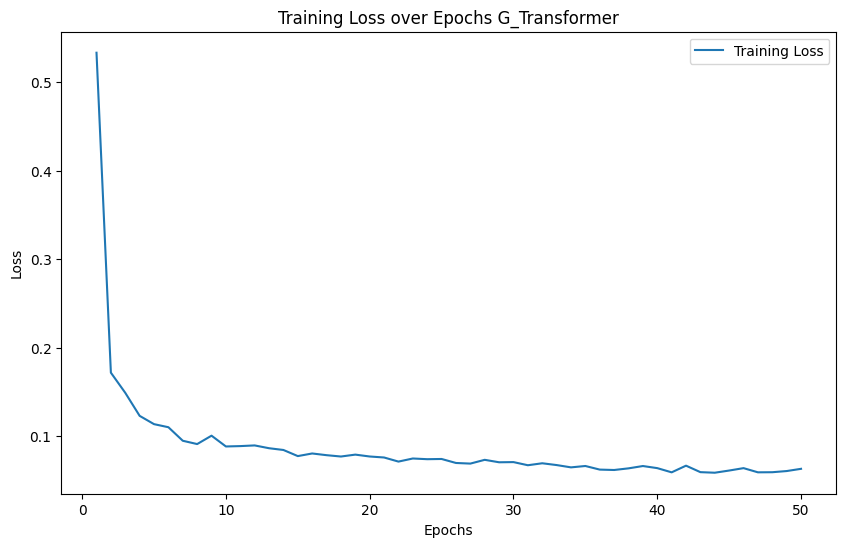

In [38]:
earlier_loss_value =[]
best_model_state,loss_values = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir,earlier_loss_value)

In [39]:
sc1_best_model_state = best_model_state

In [40]:
model.load_state_dict(best_model_state)

<All keys matched successfully>

In [54]:
model.load_state_dict(sc1_best_model_state)
save_model(model, os.path.join(model_dir, f'graph_after_sc1_model.pth'))

In [41]:
file_path = xlsx_files[2]
print(file_path)
# dt_sc1 = pd.read_excel(file_path)
# dt_sc1['can_id'] = dt_sc1['can_id'].astype(str)

stage3_data_cleaning/v2\type2_label_merged_final_decoded_clean3.xlsx


# evaluating the result for scenario 2 with injection time 0.005 sec

100%|██████████████████████████████████████████████████████████████████████████████| 1342/1342 [00:59<00:00, 22.70it/s]


              precision    recall  f1-score   support

           0       1.00      0.85      0.92      6924
           1       0.00      0.00      0.00         6

    accuracy                           0.85      6930
   macro avg       0.50      0.43      0.46      6930
weighted avg       1.00      0.85      0.92      6930



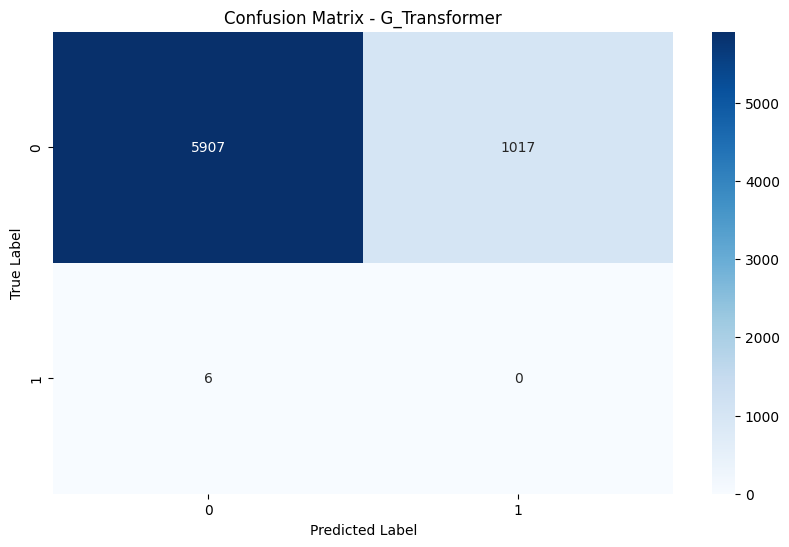

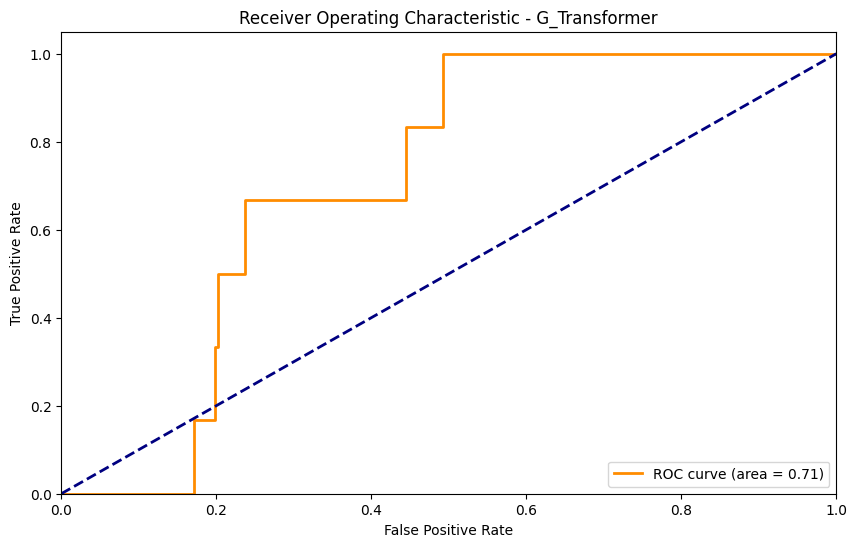

In [42]:
dt_sc2 = pd.read_excel(file_path)
dt_sc2['can_id'] = dt_sc2['can_id'].astype(str)

pyg_data_list = preprocess_data_density(dt_sc2,output_dir,visualization_dir)
test_loader = DataLoader(pyg_data_list, batch_size=32, shuffle=False)

# result not coming good
cm, report = evaluate_model(model, test_loader,title,title_dir,visualization_dir)

In [43]:
# loss_values

In [44]:
earlier_loss_value =[]
len(earlier_loss_value)

0

In [45]:
# training happening with second flooding dataset with injection time 0.0005sec

#  training on scenario 2 for the first time

In [46]:
earlier_loss_value =[]
len(earlier_loss_value)

0

Inside train model with class weights
Epoch 1, Loss: 0.5599674443593747
Epoch 2, Loss: 0.2669992227304084
Epoch 3, Loss: 0.26100325811698677
Epoch 4, Loss: 0.1588059657563766
Epoch 5, Loss: 0.16313756875405533
Epoch 6, Loss: 0.19208302007367214
Epoch 7, Loss: 0.11362401165422939
Epoch 8, Loss: 0.12078145148587369
Epoch 9, Loss: 0.06983985861075953
Epoch 10, Loss: 0.07242314992583401
Epoch 11, Loss: 0.04980798491964206
Epoch 12, Loss: 0.06726627106157441
Epoch 13, Loss: 0.08563572574972309
Epoch 14, Loss: 0.04972352613029735
Epoch 15, Loss: 0.045082529444092266
Epoch 16, Loss: 0.03290763926287625
Epoch 17, Loss: 0.03203649350464167
Epoch 18, Loss: 0.0284248716417919
Epoch 19, Loss: 0.024299407719462623
Epoch 20, Loss: 0.033911419548704066
Epoch 21, Loss: 0.03202643754914226
Epoch 22, Loss: 0.023307142497894045
Epoch 23, Loss: 0.01218190059054385
Epoch 24, Loss: 0.08962810941271268
Epoch 25, Loss: 0.041798178354275434
Epoch 26, Loss: 0.018462637852367368
Epoch 27, Loss: 0.012829932879651

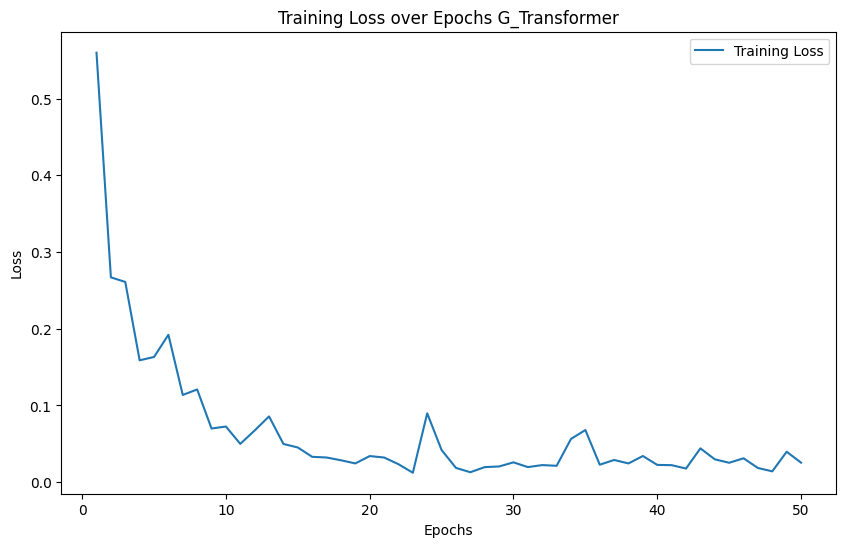

In [47]:
model.load_state_dict(sc1_best_model_state)

train_loader = test_loader
best_model_state,loss_values = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir,earlier_loss_value,retrain=False)

# 50 epochs done above not satisfied with the current loss so load the best model weights and train again

50
Inside train model with class weights
Epoch 1, Loss: 0.021067409259904663
Epoch 2, Loss: 0.015577460140255945
Epoch 3, Loss: 0.026801870506633782
Epoch 4, Loss: 0.03147580480435863
Epoch 5, Loss: 0.01960062717435427
Epoch 6, Loss: 0.011626995533290375
Epoch 7, Loss: 0.031057215182694824
Epoch 8, Loss: 0.026286133962414516
Epoch 9, Loss: 0.01684259558221259
Epoch 10, Loss: 0.01670790762381373
Epoch 11, Loss: 0.015111857829088833
Epoch 12, Loss: 0.060105886567596044
Epoch 13, Loss: 0.03532680978033958
Epoch 14, Loss: 0.03346760866476134
Epoch 15, Loss: 0.020058948413601944
Epoch 16, Loss: 0.011203212254345306
Epoch 17, Loss: 0.01215225334644423
Epoch 18, Loss: 0.015434916821548194
Epoch 19, Loss: 0.060861466451093464
Epoch 20, Loss: 0.04071953699236647
Epoch 21, Loss: 0.017490620380461525
Epoch 22, Loss: 0.017044429437235175
Epoch 23, Loss: 0.027256506157018953
Epoch 24, Loss: 0.023202013828614282
Epoch 25, Loss: 0.024082425023412464
Epoch 26, Loss: 0.04034182917287884
Epoch 27, Loss:

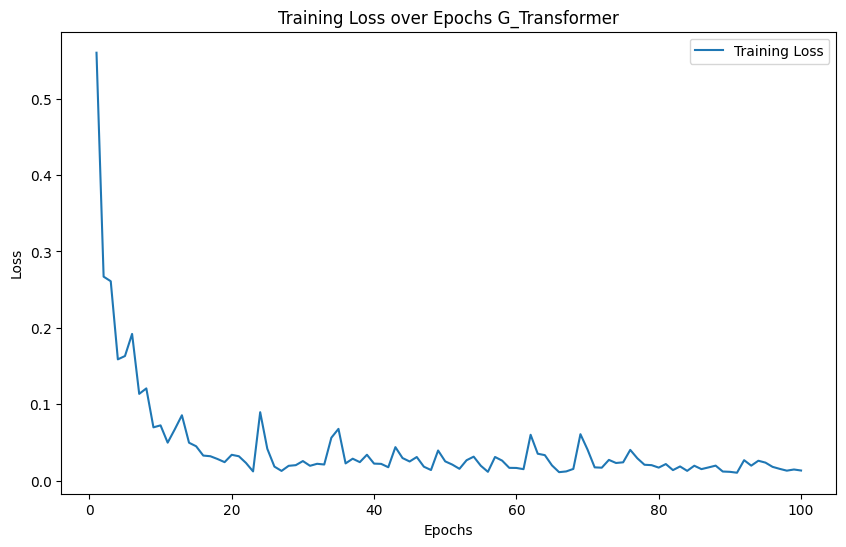

In [48]:
earlier_loss_value = loss_values
print(len(earlier_loss_value))

model.load_state_dict(best_model_state)
best_model_state,loss_values = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir,earlier_loss_value,retrain=True)

100
Inside train model with class weights
Epoch 1, Loss: 0.013848940166921932
Epoch 2, Loss: 0.012241119181843325
Epoch 3, Loss: 0.015028406655584973
Epoch 4, Loss: 0.015017133591061878
Epoch 5, Loss: 0.01564428414816835
Epoch 6, Loss: 0.017213544468090515
Epoch 7, Loss: 0.012915393912234799
Epoch 8, Loss: 0.019101285437153864
Epoch 9, Loss: 0.013332538403790836
Epoch 10, Loss: 0.0127228148167411
Epoch 11, Loss: 0.01173611153786797
Epoch 12, Loss: 0.012189468853605268
Epoch 13, Loss: 0.030433593673955157
Epoch 14, Loss: 0.014307142157728473
Epoch 15, Loss: 0.009987691671302031
Epoch 16, Loss: 0.014865637969446002
Epoch 17, Loss: 0.013961008279390322
Epoch 18, Loss: 0.010719271012064945
Epoch 19, Loss: 0.01548610405578594
Epoch 20, Loss: 0.011136234720349117
Epoch 21, Loss: 0.009789282074312464
Epoch 22, Loss: 0.013267408351739937
Epoch 23, Loss: 0.012422866058754846
Epoch 24, Loss: 0.028052670357629678
Epoch 25, Loss: 0.017875610149141203
Epoch 26, Loss: 0.017928070571152994
Epoch 27, 

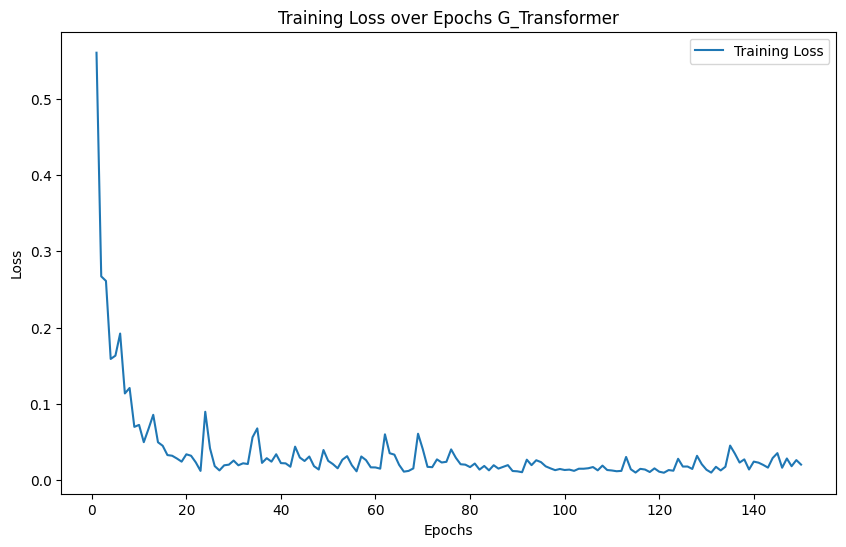

In [49]:
earlier_loss_value = loss_values
print(len(earlier_loss_value))

model.load_state_dict(best_model_state)
best_model_state,loss_values = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir,earlier_loss_value,retrain=True)

150
Inside train model with class weights
Epoch 1, Loss: 0.011967586199413441
Epoch 2, Loss: 0.012546324608722768
Epoch 3, Loss: 0.027102855889703886
Epoch 4, Loss: 0.018777317116646805
Epoch 5, Loss: 0.015418365820161333
Epoch 6, Loss: 0.012124986691473862
Epoch 7, Loss: 0.017192025752419363
Epoch 8, Loss: 0.0158470875571116
Epoch 9, Loss: 0.018097977504242278
Epoch 10, Loss: 0.01614443939234618
Epoch 11, Loss: 0.01192020990111771
Epoch 12, Loss: 0.012357789683283911
Epoch 13, Loss: 0.01155138845199742
Epoch 14, Loss: 0.011586949196953356
Epoch 15, Loss: 0.00818915737961236
Epoch 16, Loss: 0.009045603995326971
Epoch 17, Loss: 0.01034119984239537
Epoch 18, Loss: 0.00870282645848333
Epoch 19, Loss: 0.016398923255121104
Epoch 20, Loss: 0.013445137151155081
Epoch 21, Loss: 0.010471662707697674
Epoch 22, Loss: 0.013197979875231101
Epoch 23, Loss: 0.016887683501647103
Epoch 24, Loss: 0.01913248089944578
Epoch 25, Loss: 0.013755175211069096
Epoch 26, Loss: 0.012114419914377365
Epoch 27, Loss

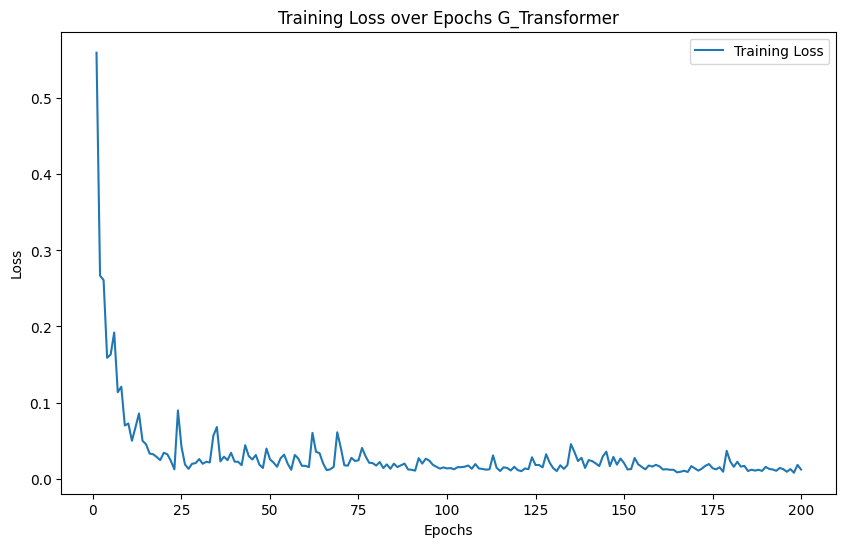

In [50]:
earlier_loss_value = loss_values
print(len(earlier_loss_value))

model.load_state_dict(best_model_state)
best_model_state,loss_values = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir,earlier_loss_value,retrain=True)

200
Inside train model with class weights
Epoch 1, Loss: 0.0109879825008864
Epoch 2, Loss: 0.016094996255170763
Epoch 3, Loss: 0.014478679305630933
Epoch 4, Loss: 0.011552974002153774
Epoch 5, Loss: 0.01171206987157261
Epoch 6, Loss: 0.010796453324787979
Epoch 7, Loss: 0.011794549286713888
Epoch 8, Loss: 0.0127910169681811
Epoch 9, Loss: 0.011047991644552385
Epoch 10, Loss: 0.011956470757611658
Epoch 11, Loss: 0.010460521541409392
Epoch 12, Loss: 0.010397556077667977
Epoch 13, Loss: 0.010620357747040458
Epoch 14, Loss: 0.00941196044563986
Epoch 15, Loss: 0.008113372762823343
Epoch 16, Loss: 0.01594773703775553
Epoch 17, Loss: 0.014935923366378813
Epoch 18, Loss: 0.05868944464591983
Epoch 19, Loss: 0.0683495970680226
Epoch 20, Loss: 0.07342282941750627
Epoch 21, Loss: 0.08182651416930076
Epoch 22, Loss: 0.03188630774405153
Epoch 23, Loss: 0.016331011240297465
Epoch 24, Loss: 0.06172057672544421
Epoch 25, Loss: 0.026124120589234474
Epoch 26, Loss: 0.011026946711581331
Epoch 27, Loss: 0.0

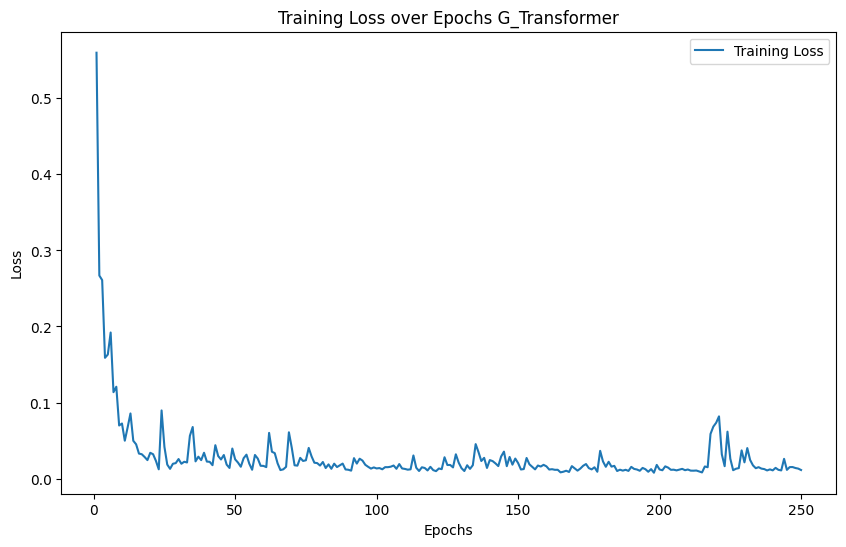

In [51]:
earlier_loss_value = loss_values
print(len(earlier_loss_value))

model.load_state_dict(best_model_state)
best_model_state,loss_values = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir,earlier_loss_value,retrain=True)

250
Inside train model with class weights
Epoch 1, Loss: 0.021730692776621992
Epoch 2, Loss: 0.018879949673040148
Epoch 3, Loss: 0.056804697294302015
Epoch 4, Loss: 0.026709728767552104
Epoch 5, Loss: 0.016200433636792393
Epoch 6, Loss: 0.0164675698972479
Epoch 7, Loss: 0.011201034225234167
Epoch 8, Loss: 0.017053493527869466
Epoch 9, Loss: 0.010981523158837566
Epoch 10, Loss: 0.038212515492020996
Epoch 11, Loss: 0.016089908548955072
Epoch 12, Loss: 0.03298083684690244
Epoch 13, Loss: 0.019340876282339672
Epoch 14, Loss: 0.012817094417446892
Epoch 15, Loss: 0.012788198462604192
Epoch 16, Loss: 0.014894621158462195
Epoch 17, Loss: 0.012626689515898414
Epoch 18, Loss: 0.010093339596572886
Epoch 19, Loss: 0.00987121792682696
Epoch 20, Loss: 0.01605827107767341
Epoch 21, Loss: 0.015600605463511047
Epoch 22, Loss: 0.013267902488440172
Epoch 23, Loss: 0.014698400196482993
Epoch 24, Loss: 0.012252806835108675
Epoch 25, Loss: 0.012610224091780592
Epoch 26, Loss: 0.015317801386031317
Epoch 27, 

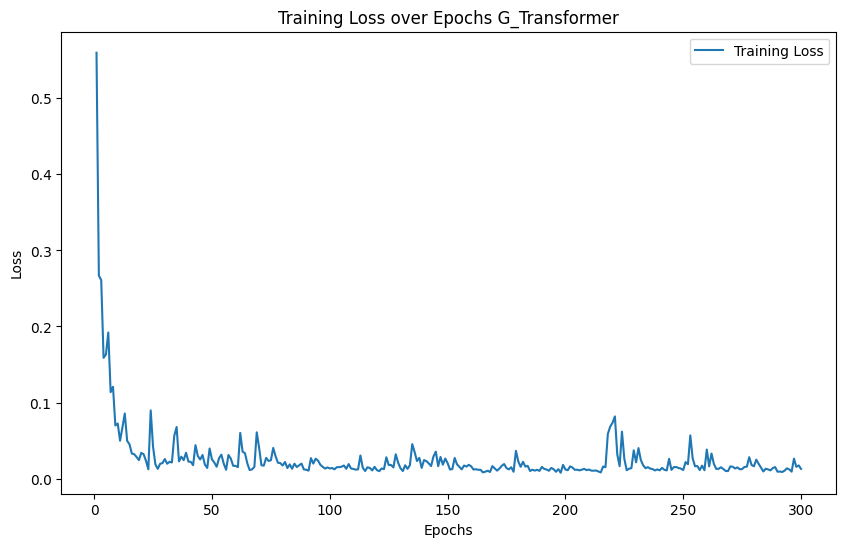

In [52]:
earlier_loss_value = loss_values
print(len(earlier_loss_value))

model.load_state_dict(best_model_state)
best_model_state,loss_values = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir,earlier_loss_value,retrain=True)

In [53]:
sc2_best_model_state = best_model_state

In [55]:
model.load_state_dict(sc2_best_model_state)
save_model(model, os.path.join(model_dir, f'graph_after_sc12_300eps_model.pth'))

# testing for scenario 3

In [57]:
file_path = xlsx_files[3]
print(file_path)

stage3_data_cleaning/v2\type3_label_merged_final_decoded_clean3.xlsx


100%|██████████████████████████████████████████████████████████████████████████████| 1975/1975 [01:22<00:00, 23.86it/s]


              precision    recall  f1-score   support

           0       0.80      1.00      0.89      6035
           1       0.80      0.01      0.02      1508

    accuracy                           0.80      7543
   macro avg       0.80      0.50      0.46      7543
weighted avg       0.80      0.80      0.72      7543



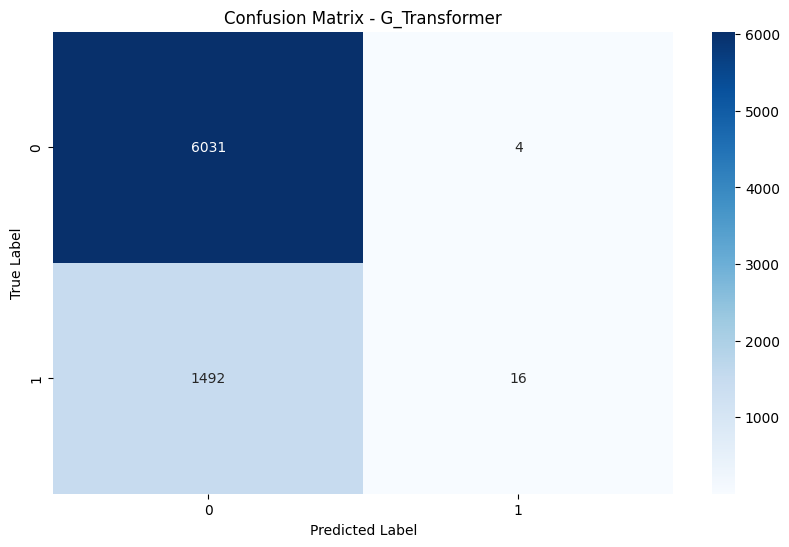

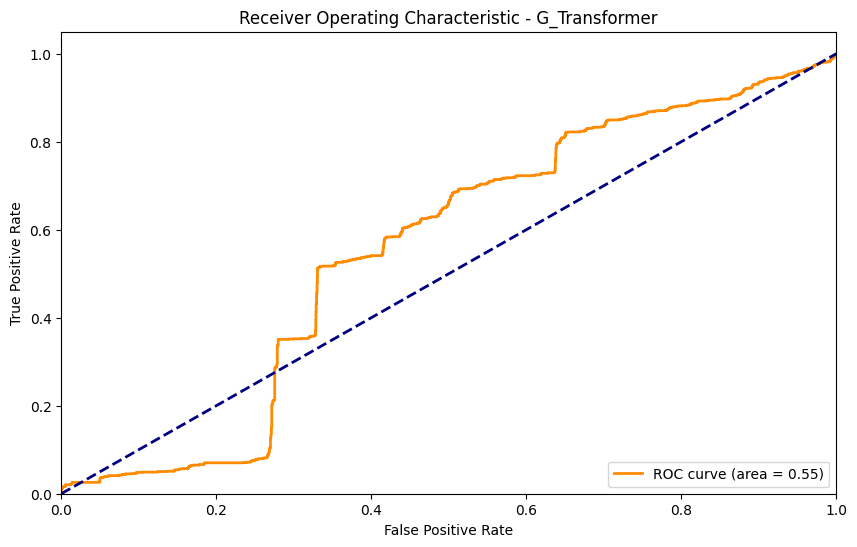

In [58]:
dt_sc3 = pd.read_excel(file_path)
dt_sc3['can_id'] = dt_sc3['can_id'].astype(str)

pyg_data_list = preprocess_data_density(dt_sc3,output_dir,visualization_dir)
test_loader = DataLoader(pyg_data_list, batch_size=32, shuffle=False)

# result not coming good
cm, report = evaluate_model(model, test_loader,title,title_dir,visualization_dir)

# not happy with the result retrain for dataset 3

In [59]:
earlier_loss_value =[]
len(earlier_loss_value)

0

Inside train model with class weights
Epoch 1, Loss: 1.01150994794455
Epoch 2, Loss: 0.23521876022700342
Epoch 3, Loss: 0.1827279950582212
Epoch 4, Loss: 0.16085236735882297
Epoch 5, Loss: 0.14784187300791662
Epoch 6, Loss: 0.14641174956435157
Epoch 7, Loss: 0.14601763184632985
Epoch 8, Loss: 0.14062106729515136
Epoch 9, Loss: 0.13288840651512146
Epoch 10, Loss: 0.13440144335430476
Epoch 11, Loss: 0.12748527902388765
Epoch 12, Loss: 0.1276992226710483
Epoch 13, Loss: 0.12360498279092773
Epoch 14, Loss: 0.12405917321842524
Epoch 15, Loss: 0.12044146506776733
Epoch 16, Loss: 0.12302288545235511
Epoch 17, Loss: 0.12110184992273007
Epoch 18, Loss: 0.11876244468974971
Epoch 19, Loss: 0.11627845436094268
Epoch 20, Loss: 0.11339535717401773
Epoch 21, Loss: 0.11216218455604487
Epoch 22, Loss: 0.11209370189857099
Epoch 23, Loss: 0.11756764813476513
Epoch 24, Loss: 0.12210880523367275
Epoch 25, Loss: 0.11327663616788003
Epoch 26, Loss: 0.10847106846349855
Epoch 27, Loss: 0.11167967079147216
Epoc

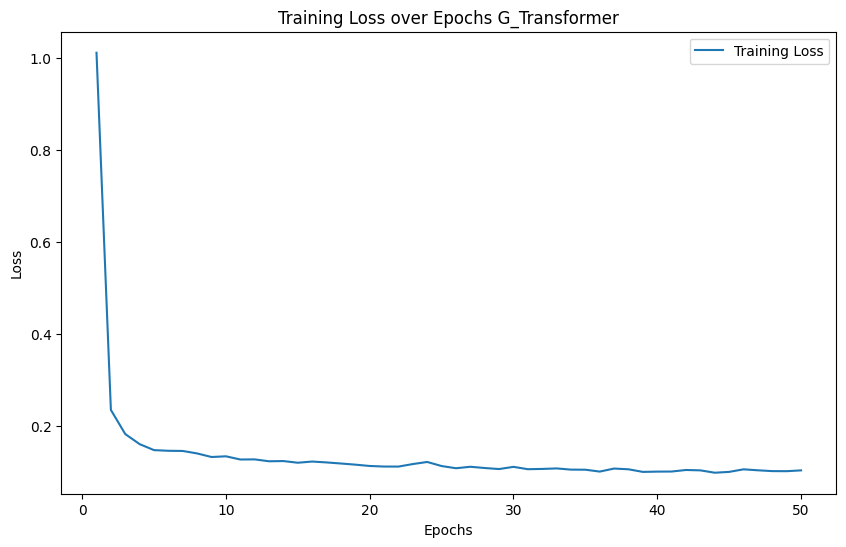

In [60]:
model.load_state_dict(sc2_best_model_state)

train_loader = test_loader
best_model_state,loss_values = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir,earlier_loss_value,retrain=False)

In [61]:
sc3_best_model_state = best_model_state

# saving model after training for 3rd dataset

In [62]:
model.load_state_dict(sc3_best_model_state)
save_model(model, os.path.join(model_dir, f'graph_after_sc3_50eps_model.pth'))

# testing with 4th Dataset

In [63]:
file_path = xlsx_files[4]
print(file_path)

stage3_data_cleaning/v2\type4_label_merged_final_decoded_clean3.xlsx


100%|██████████████████████████████████████████████████████████████████████████████| 1334/1334 [00:57<00:00, 23.24it/s]


              precision    recall  f1-score   support

           0       1.00      0.83      0.91      7702
           1       0.00      1.00      0.00         2

    accuracy                           0.83      7704
   macro avg       0.50      0.92      0.46      7704
weighted avg       1.00      0.83      0.91      7704



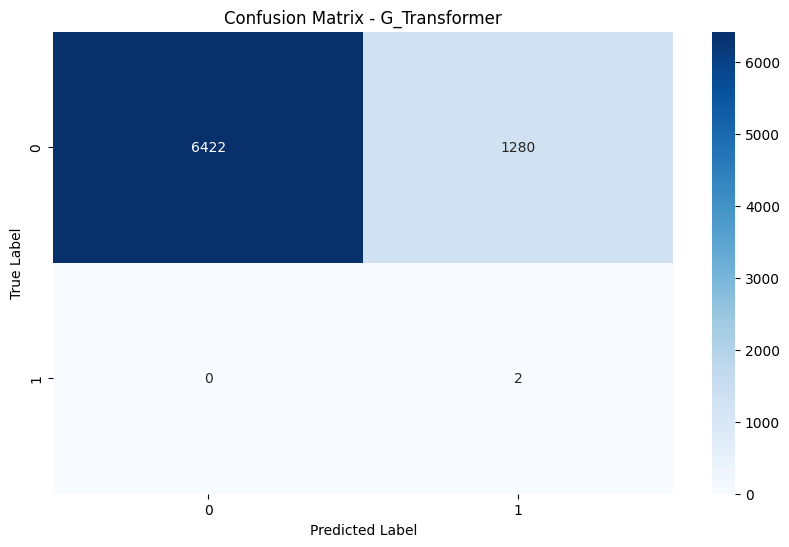

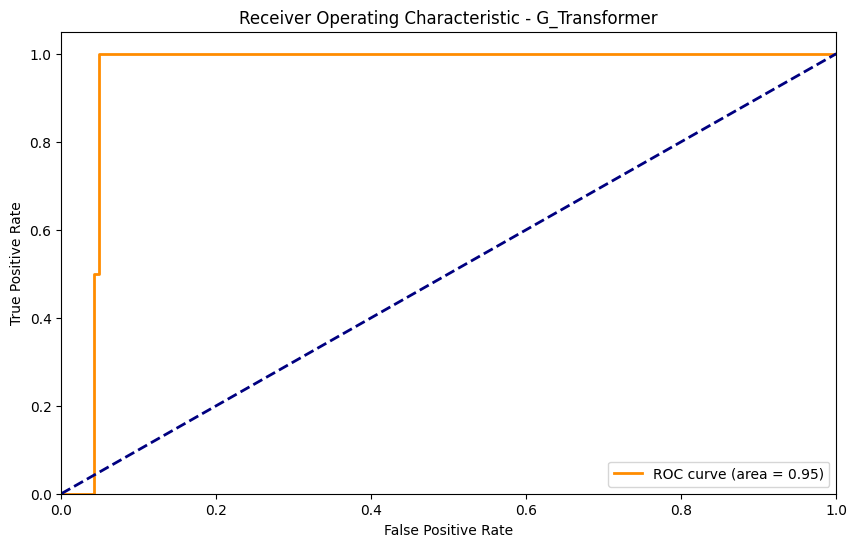

In [64]:
dt_sc4 = pd.read_excel(file_path)
dt_sc4['can_id'] = dt_sc4['can_id'].astype(str)

pyg_data_list = preprocess_data_density(dt_sc4,output_dir,visualization_dir)
test_loader = DataLoader(pyg_data_list, batch_size=32, shuffle=False)

# result not coming good
cm, report = evaluate_model(model, test_loader,title,title_dir,visualization_dir)

0
Inside train model with class weights
Epoch 1, Loss: 0.19896845217971576
Epoch 2, Loss: 0.044931803920917446
Epoch 3, Loss: 0.2106699812304777
Epoch 4, Loss: 0.0280229714089295
Epoch 5, Loss: 0.06915864303590795
Epoch 6, Loss: 0.021555259883392693
Epoch 7, Loss: 0.029626481121037312
Epoch 8, Loss: 0.09132398487556548
Epoch 9, Loss: 0.029857755275207593
Epoch 10, Loss: 0.15813360499097534
Epoch 11, Loss: 0.020523559861993862
Epoch 12, Loss: 0.009523518098701191
Epoch 13, Loss: 0.09721966201669559
Epoch 14, Loss: 0.015045324878190599
Epoch 15, Loss: 0.01621491651686873
Epoch 16, Loss: 0.03589847810993282
Epoch 17, Loss: 0.026440748122175655
Epoch 18, Loss: 0.02102662501783925
Epoch 19, Loss: 0.01615835362064813
Epoch 20, Loss: 0.09030050346193873
Epoch 21, Loss: 0.020745480790667768
Epoch 22, Loss: 0.07920613847298748
Epoch 23, Loss: 0.03601639156806327
Epoch 24, Loss: 0.020409946168088243
Epoch 25, Loss: 0.01361288457961304
Epoch 26, Loss: 0.012662128853186178
Epoch 27, Loss: 0.010711

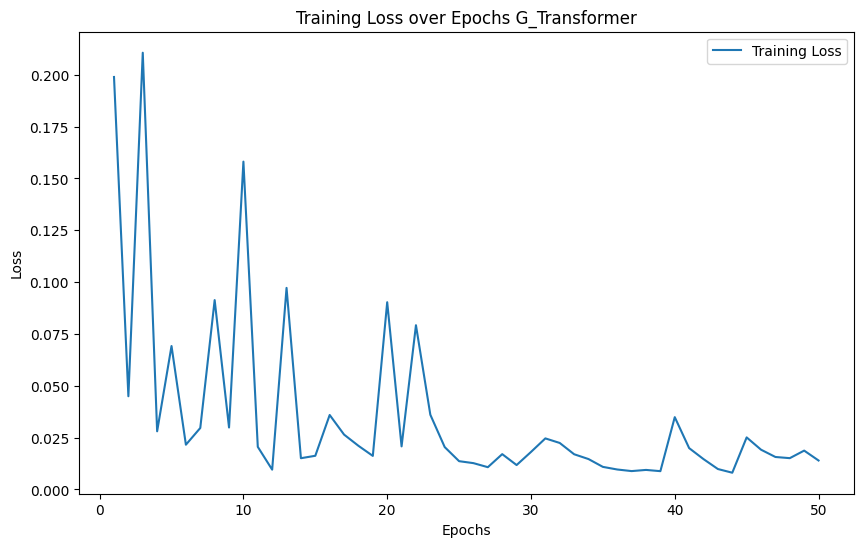

In [65]:
earlier_loss_value =[]
print(len(earlier_loss_value))

model.load_state_dict(sc3_best_model_state)

train_loader = test_loader
best_model_state,loss_values = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir,earlier_loss_value,retrain=False)

# not happy with the loss graph

50
Inside train model with class weights
Epoch 1, Loss: 0.010974490956522502
Epoch 2, Loss: 0.008181867786333896
Epoch 3, Loss: 0.015276472563398005
Epoch 4, Loss: 0.015626999125829787
Epoch 5, Loss: 0.01126350575699083
Epoch 6, Loss: 0.011709999403960648
Epoch 7, Loss: 0.009798429739367705
Epoch 8, Loss: 0.009221184114895073
Epoch 9, Loss: 0.006183094902856586
Epoch 10, Loss: 0.00792961125417995
Epoch 11, Loss: 0.052307544803105496
Epoch 12, Loss: 0.014016628367244266
Epoch 13, Loss: 0.009848106840460483
Epoch 14, Loss: 0.014382133613772956
Epoch 15, Loss: 0.008417500964502065
Epoch 16, Loss: 0.008205892851124406
Epoch 17, Loss: 0.03109189703700178
Epoch 18, Loss: 0.03096130519450179
Epoch 19, Loss: 0.019289396744213826
Epoch 20, Loss: 0.014017934000765394
Epoch 21, Loss: 0.019535391094558735
Epoch 22, Loss: 0.009653349973502503
Epoch 23, Loss: 0.008923981264637232
Epoch 24, Loss: 0.04120651355610573
Epoch 25, Loss: 0.021389905625948728
Epoch 26, Loss: 0.019233246901421808
Epoch 27, L

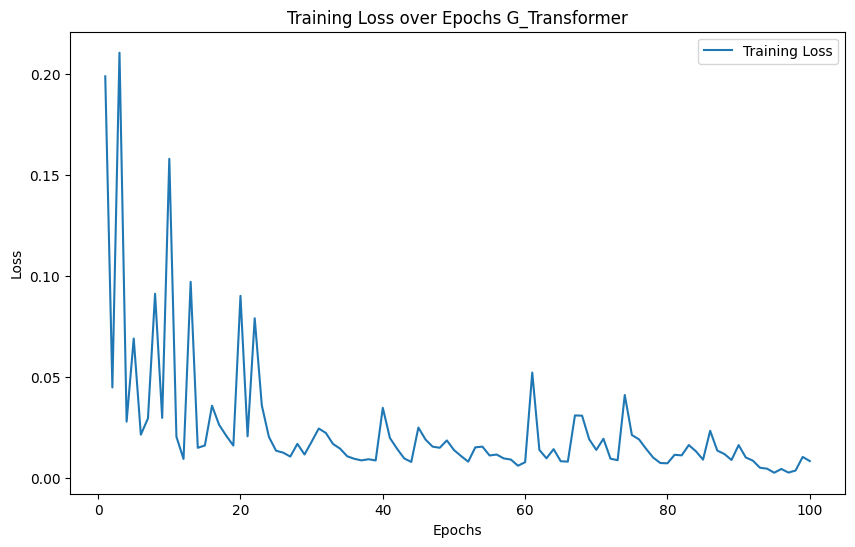

In [66]:
earlier_loss_value = loss_values
print(len(earlier_loss_value))

model.load_state_dict(best_model_state)
best_model_state,loss_values = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir,earlier_loss_value,retrain=True)

100
Inside train model with class weights
Epoch 1, Loss: 0.012463943568599504
Epoch 2, Loss: 0.006791049410074785
Epoch 3, Loss: 0.005213089971989791
Epoch 4, Loss: 0.07018474072598176
Epoch 5, Loss: 0.01293534376929442
Epoch 6, Loss: 0.00833721524824276
Epoch 7, Loss: 0.0066958584527475025
Epoch 8, Loss: 0.007848729906657224
Epoch 9, Loss: 0.04467110541846913
Epoch 10, Loss: 0.029182614718766195
Epoch 11, Loss: 0.0165910587245543
Epoch 12, Loss: 0.02262984979755683
Epoch 13, Loss: 0.023479174483556096
Epoch 14, Loss: 0.026100606665556553
Epoch 15, Loss: 0.017302745781713775
Epoch 16, Loss: 0.015166843528899812
Epoch 17, Loss: 0.016275576040719726
Epoch 18, Loss: 0.03307766932002345
Epoch 19, Loss: 0.013022541010286659
Epoch 20, Loss: 0.008624556766898465
Epoch 21, Loss: 0.008437754995698231
Epoch 22, Loss: 0.04545759272063844
Epoch 23, Loss: 0.014604083179576611
Epoch 24, Loss: 0.01435476534563696
Epoch 25, Loss: 0.006808890483929038
Epoch 26, Loss: 0.007016838128622892
Epoch 27, Loss

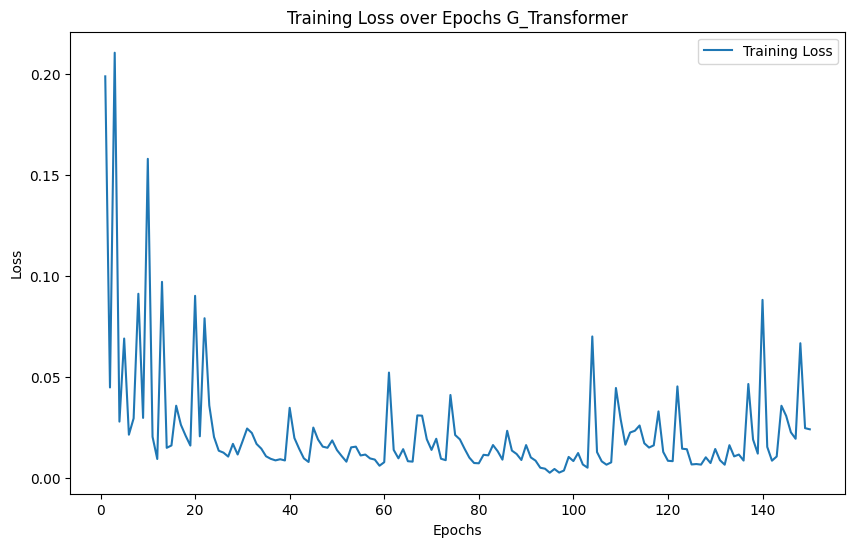

In [67]:
earlier_loss_value = loss_values
print(len(earlier_loss_value))

model.load_state_dict(best_model_state)
best_model_state,loss_values = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir,earlier_loss_value,retrain=True)

150
Inside train model with class weights
Epoch 1, Loss: 0.013780000694513291
Epoch 2, Loss: 0.012389540063884126
Epoch 3, Loss: 0.09647399342052596
Epoch 4, Loss: 0.021662588780329662
Epoch 5, Loss: 0.019813137336994385
Epoch 6, Loss: 0.018358165461962915
Epoch 7, Loss: 0.010617634509552247
Epoch 8, Loss: 0.015754374168795812
Epoch 9, Loss: 0.01112826620510329
Epoch 10, Loss: 0.01051456357263278
Epoch 11, Loss: 0.01188574379177457
Epoch 12, Loss: 0.007205895284693313
Epoch 13, Loss: 0.007068235898748197
Epoch 14, Loss: 0.05948281430443543
Epoch 15, Loss: 0.010608570300714095
Epoch 16, Loss: 0.009754038835862525
Epoch 17, Loss: 0.01179107984266704
Epoch 18, Loss: 0.008097467638868866
Epoch 19, Loss: 0.008604553654593127
Epoch 20, Loss: 0.006379906236448039
Epoch 21, Loss: 0.008106016109368716
Epoch 22, Loss: 0.005438150394292322
Epoch 23, Loss: 0.007682506969103997
Epoch 24, Loss: 0.00626130053354332
Epoch 25, Loss: 0.10134497731529077
Epoch 26, Loss: 0.023671316589505813
Epoch 27, Los

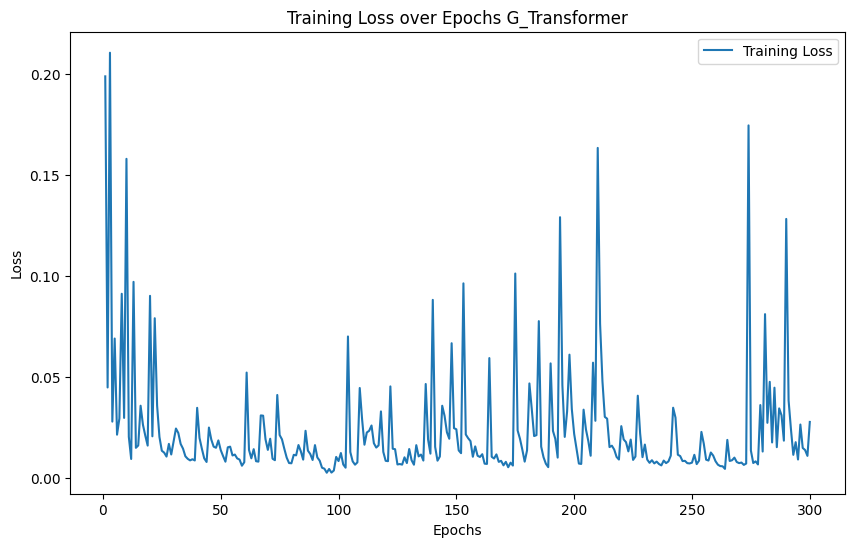

In [68]:
earlier_loss_value = loss_values
print(len(earlier_loss_value))

model.load_state_dict(best_model_state)
best_model_state,loss_values = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir,earlier_loss_value,epochs = 150,retrain=True)

300
Inside train model with class weights
Epoch 1, Loss: 0.01405130935214696
Epoch 2, Loss: 0.01846703354605425
Epoch 3, Loss: 0.010906948137447928
Epoch 4, Loss: 0.010873706988526183
Epoch 5, Loss: 0.010709497358736973
Epoch 6, Loss: 0.015347079990477701
Epoch 7, Loss: 0.0068353168138110465
Epoch 8, Loss: 0.010976579658385822
Epoch 9, Loss: 0.007346186258746998
Epoch 10, Loss: 0.007365151363772375
Epoch 11, Loss: 0.16846760265013588
Epoch 12, Loss: 0.014307217795081192
Epoch 13, Loss: 0.005727097653846158
Epoch 14, Loss: 0.0927722203749194
Epoch 15, Loss: 0.027344655217218263
Epoch 16, Loss: 0.02129727797275683
Epoch 17, Loss: 0.017512538578860887
Epoch 18, Loss: 0.009520175042845429
Epoch 19, Loss: 0.008228304687095477
Epoch 20, Loss: 0.005731187584474572
Epoch 21, Loss: 0.018342656764876404
Epoch 22, Loss: 0.04004315390632688
Epoch 23, Loss: 0.024238789106518714
Epoch 24, Loss: 0.022588242606969657
Epoch 25, Loss: 0.022758368248716927
Epoch 26, Loss: 0.009388189974440284
Epoch 27, L

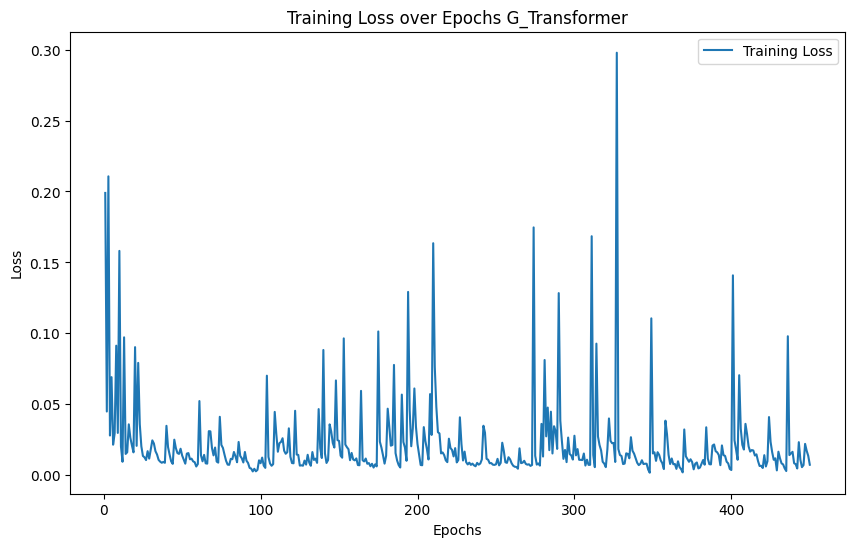

In [69]:
earlier_loss_value = loss_values
print(len(earlier_loss_value))

model.load_state_dict(best_model_state)
best_model_state,loss_values = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir,earlier_loss_value,epochs = 150,retrain=True)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7702
           1       0.20      1.00      0.33         2

    accuracy                           1.00      7704
   macro avg       0.60      1.00      0.67      7704
weighted avg       1.00      1.00      1.00      7704



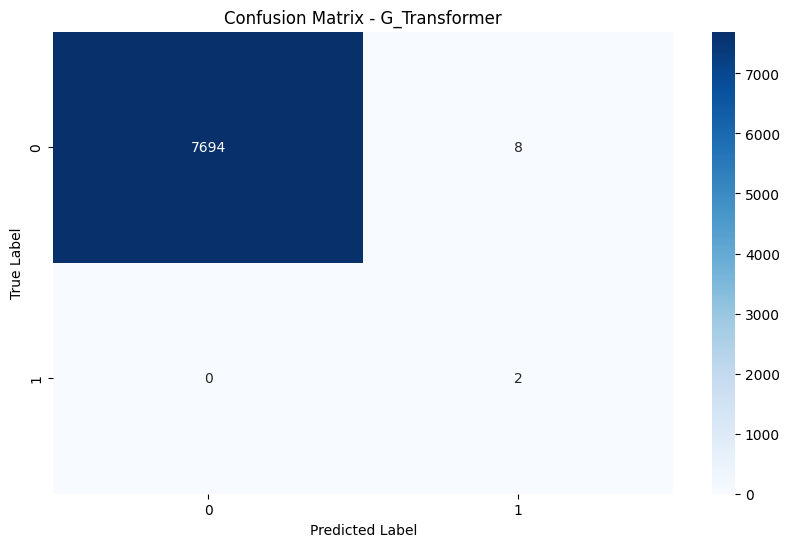

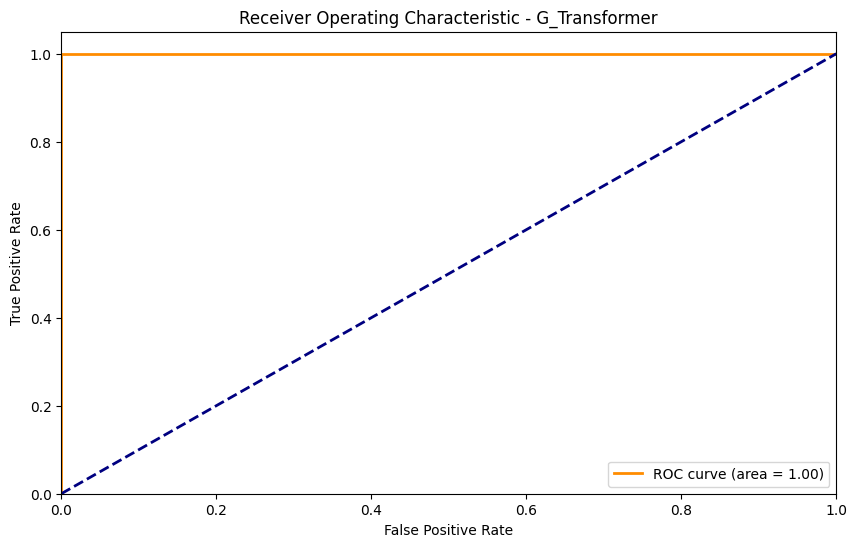

In [70]:
model.load_state_dict(best_model_state)
# result not coming good
cm, report = evaluate_model(model, test_loader,title,title_dir,visualization_dir)

450
Inside train model with class weights
Epoch 1, Loss: 0.008962669261370322
Epoch 2, Loss: 0.01189371366515686
Epoch 3, Loss: 0.011073257967034405
Epoch 4, Loss: 0.006887150443812321
Epoch 5, Loss: 0.07146966739086852
Epoch 6, Loss: 0.030098663934071943
Epoch 7, Loss: 0.011336248380733778
Epoch 8, Loss: 0.014066315575718306
Epoch 9, Loss: 0.007694266454912557
Epoch 10, Loss: 0.005866345148780509
Epoch 11, Loss: 0.002808712238378974
Epoch 12, Loss: 0.0022851259309779287
Epoch 13, Loss: 0.11112515544424613
Epoch 14, Loss: 0.1642182264816918
Epoch 15, Loss: 0.05081281688713226
Epoch 16, Loss: 0.03376871472101294
Epoch 17, Loss: 0.026233827505241572
Epoch 18, Loss: 0.015007082321016356
Epoch 19, Loss: 0.00876720271993385
Epoch 20, Loss: 0.05772333459156141
Epoch 21, Loss: 0.02960562730385434
Epoch 22, Loss: 0.02487875369955429
Epoch 23, Loss: 0.02405698798911057
Epoch 24, Loss: 0.014907842304500903
Epoch 25, Loss: 0.01708473477088595
Epoch 26, Loss: 0.008836404382189113
Epoch 27, Loss: 0

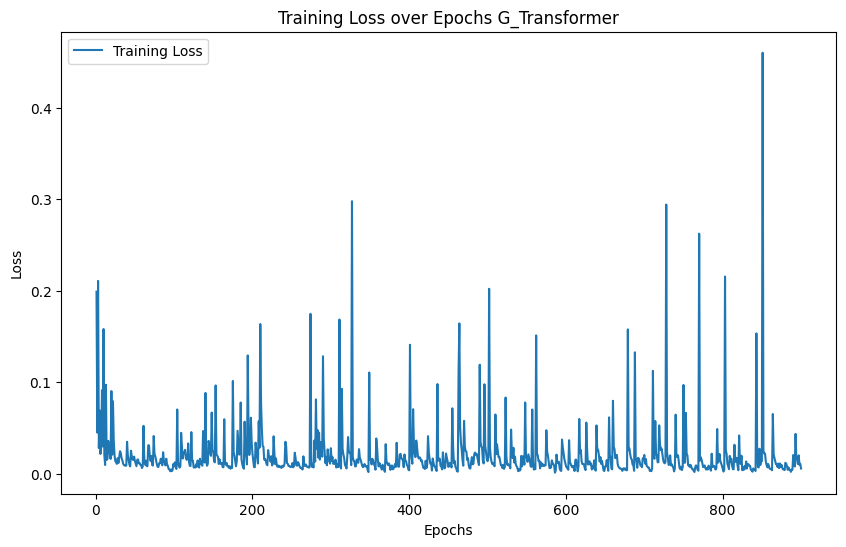

In [71]:
earlier_loss_value = loss_values
print(len(earlier_loss_value))

model.load_state_dict(best_model_state)
best_model_state,loss_values = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir,earlier_loss_value,epochs = 450,retrain=True)